In [4]:
!pip install mne

In [5]:
!pip install torch-summary

In [6]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score

In [16]:
DATASET_ROOT = '/kaggle/input/kumars-eeg-imagined-speech/Imagined_speech_EEG_edf'

# Define folders and their corresponding classes
folders = {
    'Char': {
        'path': os.path.join(DATASET_ROOT, 'Char'),
        'classes': ['A', 'C', 'F', 'H', 'J', 'M', 'P', 'S', 'T', 'Y']
    },
    'Digit': {
        'path': os.path.join(DATASET_ROOT, 'Digit'),
        'classes': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    },
    'Image': {
        'path': os.path.join(DATASET_ROOT, 'Image'),
        'classes': ['Apple', 'Car', 'Dog', 'Gold', 'Mobile', 'Rose', 'Scooter', 'Tiger', 'Wallet', 'Watch']
    }
}

char_labels_index_mapping = {
    'Char_A': 0,
    'Char_C': 1,
    'Char_F': 2,
    'Char_H': 3,
    'Char_J': 4,
    'Char_M': 5,
    'Char_P': 6,
    'Char_S': 7,
    'Char_T': 8,
    'Char_Y': 9
}

digit_labels_index_mapping = {
    'Digit_0': 0,
    'Digit_1': 1,
    'Digit_2': 2,
    'Digit_3': 3,
    'Digit_4': 4,
    'Digit_5': 5,
    'Digit_6': 6,
    'Digit_7': 7,
    'Digit_8': 8,
    'Digit_9': 9
}

image_labels_index_mapping = {
    'Image_Apple': 0,
    'Image_Car': 1,
    'Image_Dog': 2,
    'Image_Gold': 3,
    'Image_Mobile': 4,
    'Image_Rose': 5,
    'Image_Scooter': 6,
    'Image_Tiger': 7,
    'Image_Wallet': 8,
    'Image_Watch': 9
}

char_data = None
char_labels = np.array([], dtype=np.int32)

digit_data = None
digit_labels = np.array([], dtype=np.int32)

image_data = None
image_labels = np.array([], dtype=np.int32)

min_timepoints = 1408
# Loop over folders and read each EDF file
for folder_key, info in folders.items():
    folder_path = info['path']
    file_list = [fname for fname in os.listdir(folder_path)]    
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        
        # Reading and preprocessing raw data
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        # Highpass filtering above 0.5 Hz
        raw.filter(l_freq=0.5, h_freq = 60, method='iir', verbose=False)
        # Notch filter for Removal of Line Voltage Noise
        raw.notch_filter(freqs=50, verbose=False)
        
        data = raw.get_data()
        n_times = data.shape[1]
        data = (raw.get_data())[:, :min_timepoints]
        # Labels
        parts = file.split('_')
        file_label = parts[1].replace('.edf', '')
        if folder_key == 'Image':
            file_label = file_label.capitalize()
        class_name = f"{folder_key}_{file_label}"
        
        if folder_key == 'Char':
            label = char_labels_index_mapping[class_name]
            char_labels = np.append(char_labels, label)
            if char_data is None:
                char_data = data[np.newaxis, ...]
            else:
                char_data = np.concatenate((char_data, data[np.newaxis, ...]), axis=0)
                
        elif folder_key == 'Digit':
            label = digit_labels_index_mapping[class_name]
            digit_labels = np.append(digit_labels, label)
            if digit_data is None:
                digit_data = data[np.newaxis, ...]
            else:
                digit_data = np.concatenate((digit_data, data[np.newaxis, ...]), axis=0)
                
        elif folder_key == 'Image':
            label = image_labels_index_mapping[class_name]
            image_labels = np.append(image_labels, label)
            if image_data is None:
                image_data = data[np.newaxis, ...]
            else:
                image_data = np.concatenate((image_data, data[np.newaxis, ...]), axis=0)

print("Char Data Dimension:")
print(char_data.shape)
print(char_labels.shape)
print("Digit Data Dimension:")
print(digit_data.shape)
print(digit_labels.shape)
print("Image Data Dimension:")
print(image_data.shape)
print(image_labels.shape)

Char Data Dimension:
(230, 39, 1408)
(230,)
Digit Data Dimension:
(230, 39, 1408)
(230,)
Image Data Dimension:
(230, 39, 1408)
(230,)


In [8]:
while True:
    dataset_type = input("Choose the dataset (Char, Digit, Image): ").strip().lower()
    if dataset_type == "char":
        data = char_data
        labels = char_labels
        break
    elif dataset_type == "digit":
        data = digit_data
        labels = digit_labels
        break
    elif dataset_type == "image":
        data = image_data
        labels = image_labels
        break
    else:
        print("Invalid input, please try again!")

X = (data - np.mean(data)) / np.std(data)
y = labels

# Spliting  Data: 80% for Train and 20% for Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Choosing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss Function
criterion = nn.CrossEntropyLoss()

# Converting to Tensor
X_train = torch.Tensor(X_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())

Choose the dataset (Char, Digit, Image):  Char


Size of X_train: torch.Size([184, 39, 1408])
Size of X_test: torch.Size([46, 39, 1408])
Size of y_train: torch.Size([184])
Size of y_test: torch.Size([46])


In [9]:
class TrainModel():
    def __init__(self,):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, learning_rate=0.001, batch_size=64, epochs=100):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        mse_loss = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        highest_train_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                recon, outputs = model(inputs)
                recon_loss = mse_loss(recon, inputs)
                class_loss = criterion(outputs, labels)
                loss = recon_loss + class_loss
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model


In [10]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                recon, outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                recon, outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()


In [11]:
class SDLModel(nn.Module):
    def __init__(self, channels=39, time_points=1408, classes=10, latent_dim=128, f1=64, t_layers=2, nhead=4):
        super(SDLModel, self).__init__()
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(channels, f1, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(f1, f1 * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.reduced_length = time_points // 4
        feature_dim = f1 * 2  # 128
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=nhead, batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=t_layers)
        
        self.fc_enc = nn.Linear(feature_dim, latent_dim)
        
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, feature_dim * self.reduced_length)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=feature_dim, nhead=nhead, batch_first=False)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=t_layers)
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose1d(feature_dim, f1, kernel_size=3, stride=2, padding=1, output_padding=1),  # [B, 64, 704]
            nn.ReLU(),
            nn.ConvTranspose1d(f1, channels, kernel_size=3, stride=2, padding=1, output_padding=1),     # [B, 39, 1408]
        )
        
        # Classifier
        self.classifier = nn.Linear(latent_dim, classes)
        
    def forward(self, x):
        # Encoder
        enc = self.encoder_conv(x)
        enc_t = enc.permute(2, 0, 1)
        enc_transformed = self.transformer_encoder(enc_t)
        enc_mean = enc_transformed.mean(dim=0)
        latent = self.fc_enc(enc_mean)
        
        # Decoder
        dec_input = self.fc_dec(latent)
        dec_input = dec_input.view(-1, self.reduced_length, enc.size(1))
        dec_input_t = dec_input.permute(1, 0, 2)
        dec_transformed = self.transformer_decoder(dec_input_t, enc_transformed)
        dec_features = dec_transformed.permute(1, 2, 0)
        recon = self.decoder_conv(dec_features)
        
        # Classifier
        class_logits = self.classifier(latent)
        
        return recon, class_logits

In [12]:
input_size = (39, 1408)
sdl_model = SDLModel().to(device)
summary(sdl_model, input_size)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 128, 352]            --
|    └─Conv1d: 2-1                            [-1, 64, 704]             7,552
|    └─ReLU: 2-2                              [-1, 64, 704]             --
|    └─Conv1d: 2-3                            [-1, 128, 352]            24,704
|    └─ReLU: 2-4                              [-1, 128, 352]            --
├─TransformerEncoder: 1-2                     [-1, 2, 128]              --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderLayer: 3-1      [-1, 2, 128]              593,024
|    |    └─TransformerEncoderLayer: 3-2      [-1, 2, 128]              593,024
├─Linear: 1-3                                 [-1, 128]                 16,512
├─Linear: 1-4                                 [-1, 45056]               5,812,224
├─TransformerDecoder: 1-5                     [-1, 2, 128]         

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 128, 352]            --
|    └─Conv1d: 2-1                            [-1, 64, 704]             7,552
|    └─ReLU: 2-2                              [-1, 64, 704]             --
|    └─Conv1d: 2-3                            [-1, 128, 352]            24,704
|    └─ReLU: 2-4                              [-1, 128, 352]            --
├─TransformerEncoder: 1-2                     [-1, 2, 128]              --
|    └─ModuleList: 2                          []                        --
|    |    └─TransformerEncoderLayer: 3-1      [-1, 2, 128]              593,024
|    |    └─TransformerEncoderLayer: 3-2      [-1, 2, 128]              593,024
├─Linear: 1-3                                 [-1, 128]                 16,512
├─Linear: 1-4                                 [-1, 45056]               5,812,224
├─TransformerDecoder: 1-5                     [-1, 2, 128]         

In [13]:
sdl_model = SDLModel().to(device)

# Training Hyperparameters
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel()
trained_sdl_model = trainer.train_model(sdl_model, train_dataset, learning_rate=LEARNING_RATE,
                                   batch_size=BATCH_SIZE, epochs=EPOCHS)
torch.save(trained_sdl_model.state_dict(), 'eegnet_model.pth')


Epoch 1/100, Loss: 3.6782, Accuracy: 8.15%
Epoch 2/100, Loss: 3.4409, Accuracy: 10.87%
Epoch 3/100, Loss: 3.3954, Accuracy: 5.98%
Epoch 4/100, Loss: 3.4068, Accuracy: 9.78%
Epoch 5/100, Loss: 3.3807, Accuracy: 6.52%
Epoch 6/100, Loss: 3.3734, Accuracy: 5.43%
Epoch 7/100, Loss: 3.3722, Accuracy: 6.52%
Epoch 8/100, Loss: 3.3686, Accuracy: 8.70%
Epoch 9/100, Loss: 3.3576, Accuracy: 10.33%
Epoch 10/100, Loss: 3.3574, Accuracy: 11.41%
Epoch 11/100, Loss: 3.3557, Accuracy: 10.87%
Epoch 12/100, Loss: 3.3579, Accuracy: 9.78%
Epoch 13/100, Loss: 3.3552, Accuracy: 9.78%
Epoch 14/100, Loss: 3.3471, Accuracy: 11.96%
Epoch 15/100, Loss: 3.3413, Accuracy: 12.50%
Epoch 16/100, Loss: 3.3336, Accuracy: 15.76%
Epoch 17/100, Loss: 3.3316, Accuracy: 14.13%
Epoch 18/100, Loss: 3.3186, Accuracy: 14.67%
Epoch 19/100, Loss: 3.3168, Accuracy: 12.50%
Epoch 20/100, Loss: 3.3010, Accuracy: 13.04%
Epoch 21/100, Loss: 3.2966, Accuracy: 15.76%
Epoch 22/100, Loss: 3.3189, Accuracy: 15.22%
Epoch 23/100, Loss: 3.2679, 

Choose the dataset (Char, Digit, Image):  Char


/------------------------------/
Test Accuracy: 8.70%
/------------------------------/


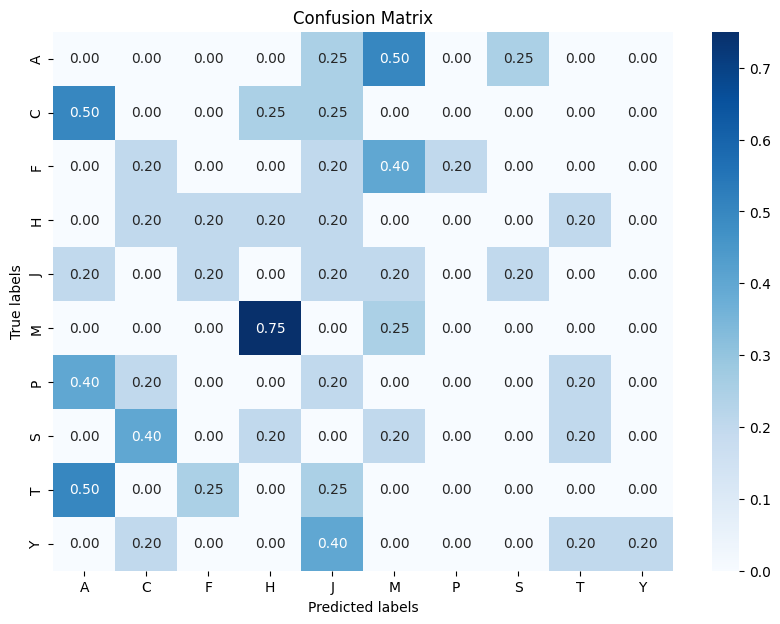

In [14]:
eval_model = EvalModel(trained_sdl_model)
while True:
    dataset_type = input("Choose the dataset (Char, Digit, Image): ").strip().lower()
    if dataset_type == "char":
        classes_list = ['A', 'C', 'F', 'H', 'J', 'M', 'P', 'S', 'T', 'Y']
        break
    elif dataset_type == "digit":
        classes_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        break
    elif dataset_type == "image":
        classes_list = ['Apple', 'Car', 'Dog', 'Gold', 'Mobile', 'Rose', 'Scooter', 'Tiger', 'Wallet', 'Watch']
        break
    else:
        print("Invalid input, please try again!")
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)
